# Step 1: Minimal Octo Inference Example

This Colab demonstrates how to load a pre-trained / finetuned Octo checkpoint, run inference on some offline images and compare the outputs to the true actions.

First, let's start with a minimal example!

In [ ]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [ ]:

from octo.model.octo_model import OctoModel

model = OctoModel.load_pretrained("hf://rail-berkeley/octo-small")

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

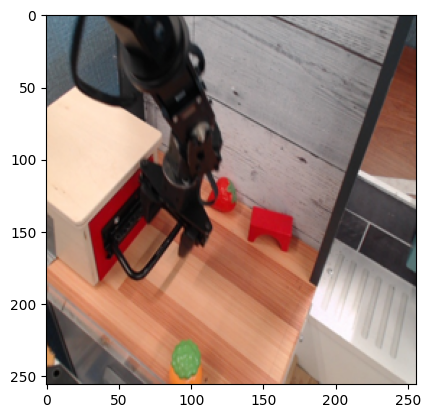

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
# download one example BridgeV2 image
IMAGE_URL = "https://rail.eecs.berkeley.edu/datasets/bridge_release/raw/bridge_data_v2/datacol2_toykitchen7/drawer_pnp/01/2023-04-19_09-18-15/raw/traj_group0/traj0/images0/im_12.jpg"
img = np.array(Image.open(requests.get(IMAGE_URL, stream=True).raw).resize((256, 256)))
plt.imshow(img)


In [ ]:
# create obs & task dict, run inference
import jax
# add batch + time horizon 1
img = img[np.newaxis,np.newaxis,...]
observation = {"image_primary": img, "pad_mask": np.array([[True]])}
task = model.create_tasks(texts=["pick up the fork"])
action = model.sample_actions(observation, task, rng=jax.random.PRNGKey(0))
print(action)   # [batch, action_chunk, action_dim]

[[[ 0.36424267  0.12472184 -0.22561233  0.3703431   0.16889247
   -0.14889258  1.0018206 ]
  [ 0.47729126  0.09780731 -0.306491    0.42572564  0.20369673
   -0.15815653  0.9905449 ]
  [ 0.46032214 -0.24522865 -0.58604044 -1.1686488   0.565213
   -0.29335126  0.9858455 ]
  [ 0.24137026 -0.44470757 -0.28508306 -1.6005151  -0.32312587
    0.28833938  1.0002182 ]]]


# Step 2: Run Inference on Full Trajectories

That was easy! Now let's try to run inference across a whole trajectory and visualize the results!

In [ ]:
# Install mediapy for visualization
!pip install mediapy
!pip install opencv-python

In [ ]:
import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

## Load Model Checkpoint
First, we will load the pre-trained checkpoint using the `load_pretrained()` function. You can simply feed the path to a checkpoint directory or the HuggingFace path of your Octo model of choice.

Below, we are loading directly from HuggingFace.


In [ ]:
from octo.model.octo_model import OctoModel

model = OctoModel.load_pretrained("hf://rail-berkeley/octo-small")

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

## Load Datasets
Next, we will load a trajectory from the bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [ ]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
ds = builder.as_dataset(split='train[:1]')

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(ds))
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (256, 256)) for step in steps]

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images, fps=10)

Instruction: Place the can to the left of the pot.


## Run Inference

Next, we will run inference over the images in the episode using the loaded model. 
Below we demonstrate setups for both, goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [ ]:
WINDOW_SIZE = 2

# create `task` dict
task = model.create_tasks(goals={"image_primary": goal_image[None]})   # for goal-conditioned
task = model.create_tasks(texts=[language_instruction])                  # for language conditioned

In [ ]:
# run inference loop, this model only uses single image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_images = np.stack(images[step:step+WINDOW_SIZE])[None]
    observation = {
        'image_primary': input_images,
        'pad_mask': np.full((1, input_images.shape[1]), True, dtype=bool)
    }
    
    # this returns *normalized* actions --> we need to unnormalize using the dataset statistics
    norm_actions = model.sample_actions(observation, task, rng=jax.random.PRNGKey(0))
    norm_actions = norm_actions[0]   # remove batch
    actions = (
        norm_actions * model.dataset_statistics["bridge_dataset"]['action']['std']
        + model.dataset_statistics["bridge_dataset"]['action']['mean']
    )
    
    pred_actions.append(actions)
    final_window_step = step + WINDOW_SIZE - 1
    true_actions.append(np.concatenate(
        (
            steps[final_window_step]['action']['world_vector'], 
            steps[final_window_step]['action']['rotation_delta'], 
            np.array(steps[final_window_step]['action']['open_gripper']).astype(np.float32)[None]
        ), axis=-1
    ))

## Visualize predictions and ground-truth actions

Finally, we will visualize the predicted actions in comparison to the groundtruth actions.

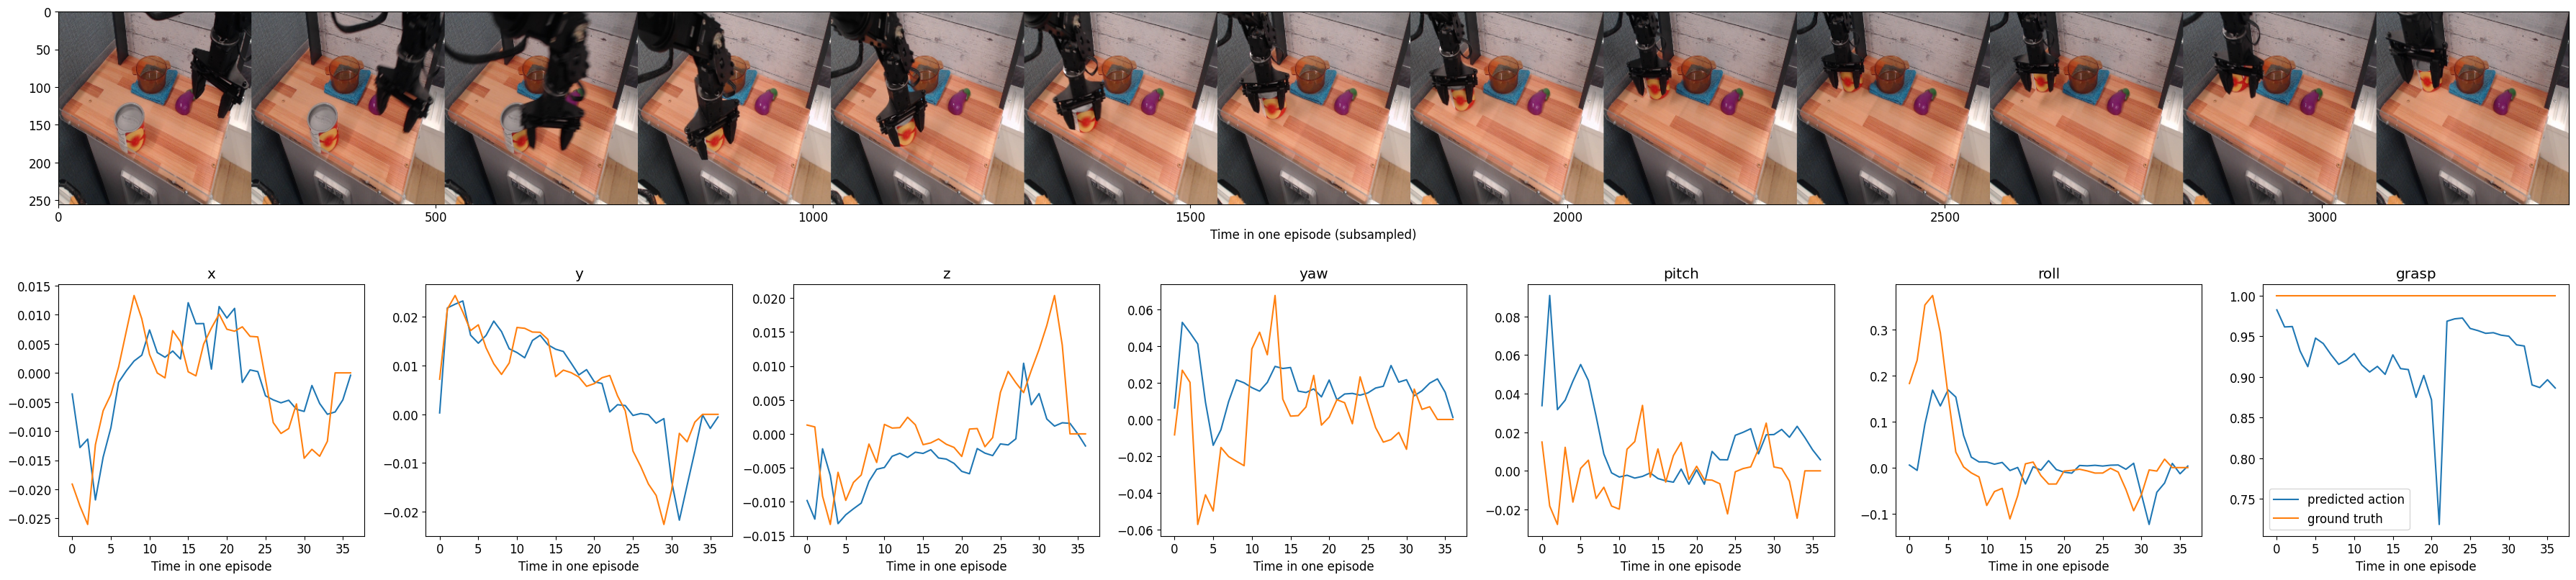

In [ ]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()